# BGG Recommendation model
This notebook explores a ready model for BGG recommendations

In [1]:
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot
import glob
import numpy as np
import seaborn as sns

## Sample data
The original data included a comment from the user, the game_id column was called "ID", and it had an "Unnamed: 0" column as an index. The applies changes to make the data more useable, and the sample data presented is more similar to the shuffled data

In [2]:
sample_train = pd.DataFrame([
    ('1000salmons',157354,8.0),
    ('1000salmons',128882,7.5),
    ('1000salmons',2407,4.5),
    ('1000salmons',178900,8.0),
    ('1000salmons',1294,5.0),
    ('1000salmons',12194,7.0),
    ('1000salmons',146735,7.0),
    ('1000salmons',70919,7.5),
    ('1000salmons',1406,5.0),
    ('1000salmons',1293,6.0),
    ('1000salmons',67877,6.5),
    ('1000salmons',84876,9.0),
    ('1000salmons',36218,8.5),
    ('1000salmons',19796,6.0),
    ('1000salmons',2381,6.0),
    ('1000salmons',50381,6.5),
], 
columns=['user', 'game_id', 'rating'],
index=(506155,1048906,4433087,5143551,5295373,6563448,
        6765807,6879196,8291897,8629273,10142237,10523140,
        12212202,12365209,13306961,13362454)
)

sample_test = pd.DataFrame([
    ('1000salmons',150376,7.5),
    ('1000salmons',68448,8.5),
    ('1000salmons',320,6.5),
    ('1000salmons',129622,7.5),
], 
columns=['user', 'game_id', 'rating'],
index=(13533141,14859079,14913452,15349127)
)

In [3]:
game_details_df = pd.read_csv('data/games_detailed_info.csv')
game_details_df = game_details_df.set_index('id')


Lets see the games our test user likes

In [4]:
sample_train.join(game_details_df[['primary']], on=sample_train.game_id)

,user,game_id,rating,primary
506155,1000salmons,157354,8.0,Five Tribes
1048906,1000salmons,128882,7.5,The Resistance: Avalon
4433087,1000salmons,2407,4.5,Sorry!
5143551,1000salmons,178900,8.0,Codenames
5295373,1000salmons,1294,5.0,Clue
6563448,1000salmons,12194,7.0,Munchkin Bites!
6765807,1000salmons,146735,7.0,Munchkin Adventure Time
6879196,1000salmons,70919,7.5,Takenoko
8291897,1000salmons,1406,5.0,Monopoly
8629273,1000salmons,1293,6.0,Boggle


We are ready to start playing. First of all, lets load the rating pipline

# Fitting the user
Unlike other models in machine learning, recommendation systems have to do some fitting on the traning data past the model creation. This fitting method is designed to handle new user data, and does not affect the model. That's why we use transform on the data, instead of predict.
We'll do some data exploration later

In [5]:
from prepare_comments import get_pipeline
pipeline = get_pipeline('models/encoded_games_detailed_info.fethear')

train_y = sample_train['rating']
test_y = sample_test['rating']

train_X = pipeline.fit_transform(sample_train.drop('rating', axis=1), train_y)
test_X = pipeline.transform(sample_test.drop('rating', axis=1))

train_X = pd.DataFrame(train_X, columns=pipeline.steps[-1][1].get_feature_names())
test_X = pd.DataFrame(test_X, columns=pipeline.steps[-1][1].get_feature_names())

The first game the user reviwed was "Five Tribes". Here are the game details from the original table

In [6]:
game_details_df[game_details_df['primary'] == 'Five Tribes'][
    ['yearpublished', 'minplayers', 'maxplayers', 'boardgamecategory', 'boardgamemechanic', 'averageweight']
].iloc[0]

yearpublished                                                     2014
minplayers                                                           2
maxplayers                                                           4
boardgamecategory       ['Animals', 'Arabian', 'Fantasy', 'Mythology']
boardgamemechanic    ['Auction/Bidding', 'End Game Bonuses', 'Hidde...
averageweight                                                   2.8516
Name: 157354, dtype: object

In [7]:
train_X[ ['game__review__count', 'game__review__mean_plus_std', 'game__review__mean_minus_std'] ]

,game__review__count,game__review__mean_plus_std,game__review__mean_minus_std
0,54354.0,9.068371,6.500402
1,46701.0,9.109657,6.063849
2,9903.0,6.255981,2.746737
3,112776.0,8.926790,6.350360
4,29862.0,7.170194,4.182300
5,5289.0,7.651959,4.263583
6,2649.0,8.102111,4.841989
7,59553.0,8.458135,6.095495
8,48096.0,6.197650,2.511492
9,12114.0,7.795083,4.619231


In [8]:
train_X[
    ['game__weight__less_than_0.50', 'game__weight__2.01-2.5', 'game__weight__2.51-3.0', 'game__players__couples', 'game__players__multiplayers', 'game__players__party', 'game__category__card_game', 'game__category__fantasy', 'game__desc_nlp__five', 'game__desc_nlp__win', 'game__desc_nlp__dice']
].iloc[0]


game__weight__less_than_0.50    0.000000
game__weight__2.01-2.5          0.000000
game__weight__2.51-3.0          1.000000
game__players__couples          1.000000
game__players__multiplayers     1.000000
game__players__party            0.000000
game__category__card_game       0.000000
game__category__fantasy         1.000000
game__desc_nlp__five            0.458203
game__desc_nlp__win             0.105453
game__desc_nlp__dice            0.000000
Name: 0, dtype: float64

### user data

In [9]:
train_X[ ['user_reviews__count', 'user_reviews__mean_plus_std', 'user_reviews__mean_minus_std'] ].head(5)

,user_reviews__count,user_reviews__mean_plus_std,user_reviews__mean_minus_std
0,16.0,17.30384,14.69616
1,16.0,17.30384,14.69616
2,16.0,17.30384,14.69616
3,16.0,17.30384,14.69616
4,16.0,17.30384,14.69616


In [10]:
train_X[
    ['sum__weight__less_than_0.50', 'sum__weight__2.01-2.5', 'sum__weight__2.51-3.0', 'sum__players__couples', 'sum__players__multiplayers', 'sum__players__party', 'sum__category__card_game', 'sum__category__fantasy', 'sum__desc_nlp__five', 'sum__desc_nlp__win', 'sum__desc_nlp__dice']
].iloc[0]

sum__weight__less_than_0.50     0.000000
sum__weight__2.01-2.5           1.000000
sum__weight__2.51-3.0           2.000000
sum__players__couples          15.000000
sum__players__multiplayers     16.000000
sum__players__party            11.000000
sum__category__card_game        6.000000
sum__category__fantasy          3.000000
sum__desc_nlp__five             1.003577
sum__desc_nlp__win              0.892038
sum__desc_nlp__dice             0.437331
Name: 0, dtype: float64

In [11]:
train_X[
    ['mean__weight__less_than_0.50', 'mean__weight__2.01-2.5', 'mean__weight__2.51-3.0', 'mean__players__couples', 'mean__players__multiplayers', 'mean__players__party', 'mean__category__card_game', 'mean__category__fantasy', 'mean__desc_nlp__five', 'mean__desc_nlp__win', 'mean__desc_nlp__dice']
].iloc[0]

mean__weight__less_than_0.50   -1.000000
mean__weight__2.01-2.5          8.500000
mean__weight__2.51-3.0          8.500000
mean__players__couples          6.800000
mean__players__multiplayers     6.750000
mean__players__party            6.409091
mean__category__card_game       7.416667
mean__category__fantasy         7.500000
mean__desc_nlp__five            1.389940
mean__desc_nlp__win             1.064370
mean__desc_nlp__dice            1.043670
Name: 0, dtype: float64

## The model
Before stating, lets have a look at the model performance history (measured against validation group, in a 40 minuetes learning process), and the key metrics of the model

<AxesSubplot:>

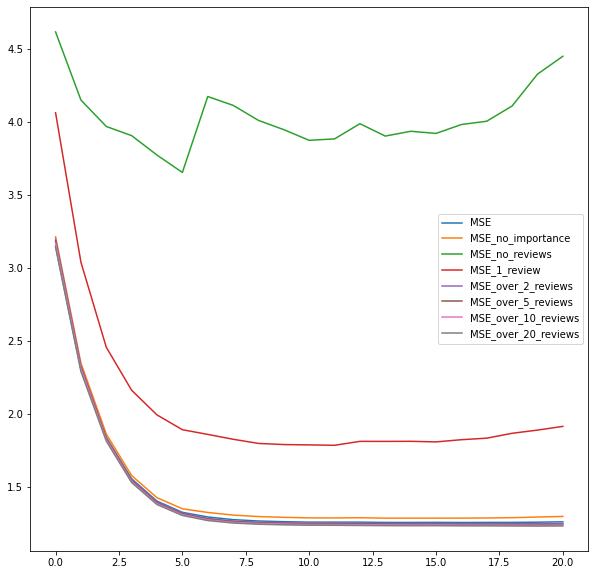

In [12]:
history = pd.read_csv('models/loss_history.csv')
axes = []
history[['MSE', 'MSE_no_importance', 'MSE_no_reviews', 'MSE_1_review', 
        'MSE_over_2_reviews', 'MSE_over_5_reviews', 'MSE_over_10_reviews', 'MSE_over_20_reviews', ]].plot( figsize=(10,10) )


<AxesSubplot:>

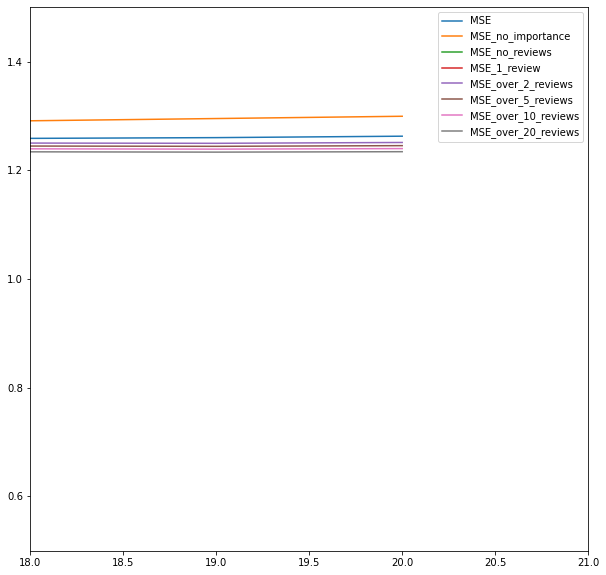

In [13]:
history[['MSE', 'MSE_no_importance', 'MSE_no_reviews', 'MSE_1_review', 
        'MSE_over_2_reviews', 'MSE_over_5_reviews', 'MSE_over_10_reviews', 'MSE_over_20_reviews', ]].plot( figsize=(10,10), ylim=(0.5,1.5), xlim=(18, 21) )

In [14]:
history.iloc[-1]

Unnamed: 0             20.000000
iter                   20.000000
filenum                20.000000
batch                   0.000000
MSE                     1.262705
MSE_no_importance       1.299371
MSE_no_reviews          4.447667
MSE_1_review            1.915577
MSE_over_2_reviews      1.251151
MSE_over_5_reviews      1.245318
MSE_over_10_reviews     1.239894
MSE_over_20_reviews     1.234185
Name: 20, dtype: float64

## Test performance evaluation
We kept a portion for evalutaing on test group these are our results

,Loss
Loss type,
Weighted,1.242233
Not weighted,1.299436
no reviews,4.451930
1 review,1.925840
over 2 review,1.250599
over 5 review,1.244608
over 10 review,1.239027
over 20 review,1.233346


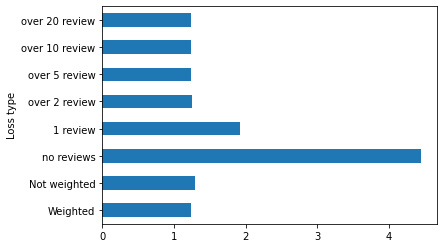

In [15]:
test_loss = pd.read_csv('models/sum_results.csv').set_index('Unnamed: 0')
test_loss.index.name = "Loss type"
test_loss.columns = ['Loss']
test_loss['Loss'].plot.barh()
test_loss

In [16]:
# Predicted vs results
test_results = pd.read_csv('models/full_results.csv').set_index('Unnamed: 0')


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


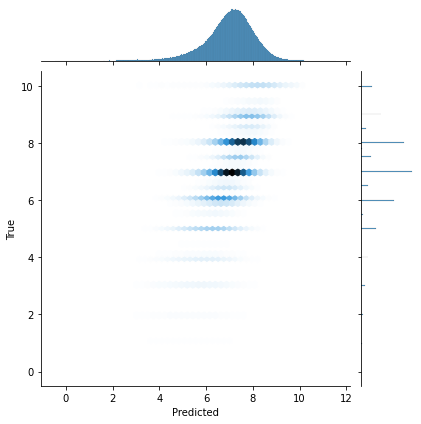

In [17]:
sns.jointplot(test_results['Predicted'],test_results['True'],  kind='hex')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


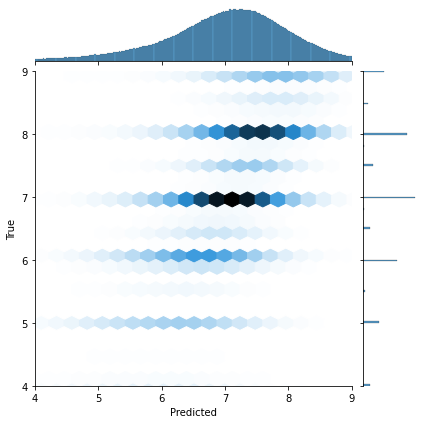

In [18]:
sns.jointplot(test_results['Predicted'],test_results['True'],  xlim=(4,9), ylim=(4,9), kind='hex')

## Our model in action

In [19]:
model = xgb.Booster()
model.load_model('models/model_data.json')

In [20]:
f_score = model.get_fscore()
f_score = dict([ (train_X.columns[ int(key.replace('f', '')) ], int(value)) for key, value in f_score.items() ])
f_score = pd.Series(f_score).sort_values(ascending=False)

In [21]:
df_f_score = f_score.to_frame().reset_index()
df_f_score = df_f_score.rename({0: 'power'}, axis=1)

<AxesSubplot:ylabel='index'>

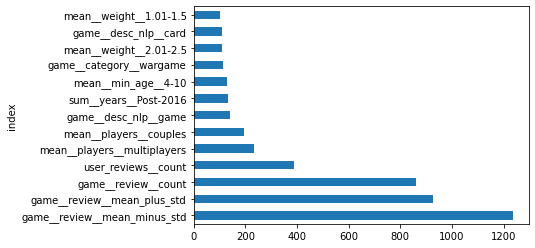

In [22]:
df_f_score.groupby('index').sum()['power'].sort_values(ascending=False).head(13).plot.barh()

## Predictions
Lets see how well our model works for this user

In [23]:
sample_predictions = pd.Series(model.predict(xgb.DMatrix(test_X)), index=sample_test.index, name='prediction')
sample_test.join(sample_predictions).join(game_details_df[['primary']], on=sample_test.game_id)


,user,game_id,rating,prediction,primary
13533141,1000salmons,150376,7.5,7.310829,Dead of Winter: A Crossroads Game
14859079,1000salmons,68448,8.5,7.521356,7 Wonders
14913452,1000salmons,320,6.5,6.598529,Scrabble
15349127,1000salmons,129622,7.5,7.615163,Love Letter


Now, lets find the best game for this user, from those he never played!

In [24]:
games_played = sample_train['game_id'].append(sample_test['game_id'])
other_games_X_base = pd.DataFrame([('1000salmons', id) 
    for id in game_details_df[ ~game_details_df.index.isin(games_played) ].index],
columns=['user', 'game_id'])

other_games_X = pipeline.transform(other_games_X_base)
other_games_X = pd.DataFrame(other_games_X, columns=pipeline.steps[-1][1].get_feature_names())


In [25]:
res = model.predict(xgb.DMatrix(other_games_X))
other_games_X_base['predicted'] = pd.Series(res)

In [26]:
other_games_X_base.join(game_details_df[['primary']], on=other_games_X_base.game_id).sort_values('predicted', ascending=False).head(10)


,user,game_id,predicted,primary
17511,1000salmons,5618,8.603914,Sports Action Canadian Pro Football
18446,1000salmons,149705,8.586160,Croquet: A Cardboard Game
13160,1000salmons,160524,8.545771,Soccer Blast Pro Soccer Game
7668,1000salmons,141067,8.543917,History Maker Baseball
18150,1000salmons,170298,8.500785,One-hour Wargames
11287,1000salmons,139747,8.485640,Arena Rex
17058,1000salmons,38562,8.479215,Song of Arthur and Merlin
18707,1000salmons,118537,8.478177,Fortress Sevastopol
16630,1000salmons,7447,8.473020,Replay Basketball
7487,1000salmons,199182,8.463495,Commands & Colors Tricorne: The American Revol...


### What would an empty user look like?
Just for kicks, even if this system does not work well with these users, let's see what's the recommended games for a user with no reviews

In [27]:
all_games_X_base = pd.DataFrame([(' Never Seen User ', id) 
    for id in game_details_df.index],
columns=['user', 'game_id'])

all_games_X = pipeline.transform(other_games_X_base)
all_games_X = pd.DataFrame(other_games_X, columns=pipeline.steps[-1][1].get_feature_names())


In [28]:
res = model.predict(xgb.DMatrix(all_games_X))
all_games_X_base['predicted'] = pd.Series(res)

In [29]:
all_games_X_base.join(game_details_df[['primary']], on=all_games_X_base.game_id).sort_values('predicted', ascending=False).head(10)

,user,game_id,predicted,primary
17511,Never Seen User,13879,8.603914,Scene it? Jr.
18446,Never Seen User,31021,8.586160,Shuffleboard Game
13160,Never Seen User,190462,8.545771,Triumph of Chaos v.2 (Deluxe Edition)
7668,Never Seen User,16142,8.543917,Geisterwäldchen
18150,Never Seen User,188493,8.500785,Sequence Cats
11287,Never Seen User,252542,8.485640,The Romans
17058,Never Seen User,23818,8.479215,1847: Pfalz
18707,Never Seen User,182410,8.478177,The First Crusade
16630,Never Seen User,252883,8.473020,TOKYO SIDEKICK
7487,Never Seen User,275034,8.463495,Judge Dredd: Helter Skelter
